In [ ]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import numpy as np
import random

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import pandas as pd
import sys
sys.path.append("../")
from qmg.utils import MoleculeQuantumStateGenerator

num_heavy_atom = 2
data_path = f"../dataset/chemical_space/effective_{num_heavy_atom}.csv"
data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16)
data = pd.read_csv(data_path)
data.head()

In [ ]:
def controlled_ry(qc, control, target, digit):
    # Apply H to target if control is |1>
    qc.ry(-np.pi/2 * digit, target)
    qc.cx(control, target)
    qc.ry(np.pi/2 * digit, target)

def build_start_atom(qc, weight_1, weight_2):
    qc.ry(np.pi * weight_1, 1)
    qc.x(2)
    qc.cx(1, 2)
    qc.cx(1, 0)
    controlled_ry(qc, 0, 2, weight_2)
    qc.cx(2, 1)

def build_second_atom(qc, weight_1, weight_2, weight_3, weight_4):
    qc.ry(np.pi * weight_1, 3)
    qc.ry(np.pi * weight_2, 4)
    qc.cx(3,4)
    controlled_ry(qc, 1, 3, weight_3)
    controlled_ry(qc, 2, 4, weight_4)
    qc.x(3)
    qc.x(4)
    qc.x(5)
    qc.ccx(3,4,5) # store the |00> state in ancilla qubit (fifth qubit).
    qc.x(3)
    qc.x(4)

def build_bond_type_circuit(qc, heavy_atom_number: int, weight_vector):
    num_target_qubit = (heavy_atom_number - 1) * 2
    assert np.sum(weight_vector) == 1.
    assert len(weight_vector) == num_target_qubit
    # ancilla qubit indicating the existence of heavy_atom_number
    ancilla_qubit_number = 2*heavy_atom_number + (heavy_atom_number-1)**2 - 1
    for i in range(2*(heavy_atom_number-1)):
        qc.cx(ancilla_qubit_number+i, ancilla_qubit_number+i+1)
    for i in range(2*(heavy_atom_number-1)):
        controlled_ry(qc, ancilla_qubit_number+num_target_qubit-i-1, ancilla_qubit_number+num_target_qubit-i, 1-weight_vector[-1-i])
    

# def build_bond_type(qc, )

# 创建一个有三个量子位的量子电路
qc = QuantumCircuit(6, 4)
build_start_atom(qc, 0.75, 0.5)
build_second_atom(qc, 0.4, 0.4, 0.4, 0.8)
# 测量所有量子位
qc.measure([1,2,3,4], [0,1,2,3])

# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=4096).result()
counts = results.get_counts(qc)

print(len(counts))
# 绘制直方图
plot_histogram(counts)
qc.draw(output="mpl")

In [ ]:
plot_histogram(counts)

[0, 1, 2, 3, 5, 6]
39


/tmp/ipykernel_264379/2241938976.py:71: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(qc, backend=simulator, shots=4096*4).result()


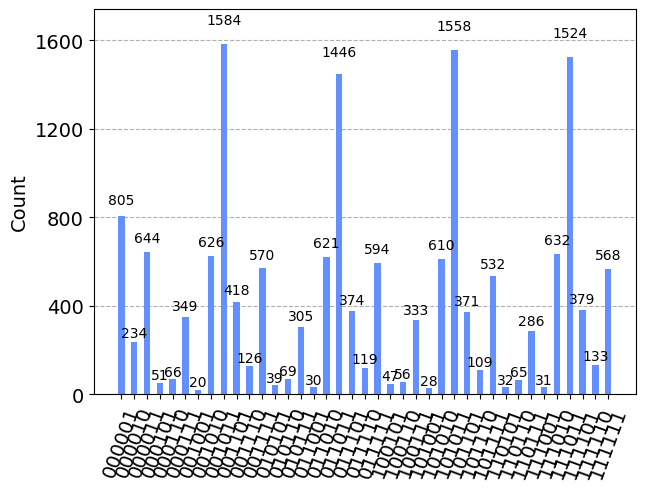

In [62]:
from typing import List, Union
import numpy as np

def controlled_ry(qc, control, target, digit):
    # Apply H to target if control is |1>
    qc.ry(-np.pi/2 * digit, target)
    qc.cx(control, target)
    qc.ry(np.pi/2 * digit, target)

def build_two_atoms(qc, weight_vector: Union[List[float], np.ndarray]):
    assert len(weight_vector) == 6
    qc.ry(np.pi * weight_vector[0], 0)
    qc.x(1)
    qc.ry(np.pi * weight_vector[2], 2)
    qc.ry(np.pi * weight_vector[4], 3)
    qc.cx(0, 1)
    controlled_ry(qc, 1, 2, weight_vector[3])
    qc.cx(2, 3)
    controlled_ry(qc, 0, 1, weight_vector[1])
    qc.cx(1, 2)
    controlled_ry(qc, 2, 3, weight_vector[5])

    qc.x(2)
    qc.x(3)
    qc.x(4)
    qc.ccx(2,3,4) # store the |00> state in ancilla qubit (fourth qubit).
    qc.x(2)
    qc.x(3)

def build_bond_type_circuit(qc, heavy_atom_number: int, weight_vector: Union[List[float], np.ndarray]):
    num_target_qubit = (heavy_atom_number - 1) * 2
    assert np.abs(np.sum(weight_vector) - 1) < 1e-5
    assert len(weight_vector) == num_target_qubit
    # ancilla qubit indicating the existence of heavy_atom_number
    ancilla_qubit_index = 2*heavy_atom_number + (heavy_atom_number-1)**2 - 1
    for i in range(2*(heavy_atom_number-1)):
        qc.cx(ancilla_qubit_index+i, ancilla_qubit_index+i+1)
    for i in range(2*(heavy_atom_number-1)):
        controlled_ry(qc, ancilla_qubit_index+num_target_qubit-i-1, ancilla_qubit_index+num_target_qubit-i, 1-weight_vector[-1-i])

def build_atom_type_circuit(qc, heavy_atom_number: int, weight_vector: Union[List[float], np.ndarray]):
    assert len(weight_vector) == 3
    ancilla_qubit_index = 2*(heavy_atom_number-1) + (heavy_atom_number-2)**2 - 1
    qubit_1_index = ancilla_qubit_index + 2*(heavy_atom_number - 2) + 1
    qubit_2_index = qubit_1_index + 1
    qc.cx(ancilla_qubit_index, qubit_1_index)
    controlled_ry(qc, qubit_1_index, qubit_2_index, weight_vector[1])
    controlled_ry(qc, ancilla_qubit_index, qubit_1_index, weight_vector[0])
    qc.cx(qubit_2_index, qubit_1_index)
    controlled_ry(qc, qubit_1_index, qubit_2_index, weight_vector[2])

    
num_heavy_atom = 2
num_qubits = num_heavy_atom*(num_heavy_atom+1)
num_ancilla_qubits = num_heavy_atom - 1
qc = QuantumCircuit(num_qubits+num_ancilla_qubits, num_qubits)
build_two_atoms(qc, [0.7, 0.3, 0.6, 0.3, 0.2, 0.6])
build_bond_type_circuit(qc, 2, [0.5, 0.5])

effective_qubit_index = list(range(num_qubits+num_ancilla_qubits))
for j in range(2, num_heavy_atom+1):
    ancilla_qubit_number = 2*j + (j-1)**2 - 1
    effective_qubit_index.remove(ancilla_qubit_number)
print(effective_qubit_index)
qc.measure(effective_qubit_index, list(range(num_qubits)))

# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=4096*4).result()
counts = results.get_counts(qc)

print(len(counts))
plot_histogram(counts)
# qc.draw(output="mpl")

/beegfs/home/lungyi45/.conda/envs/qmg/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


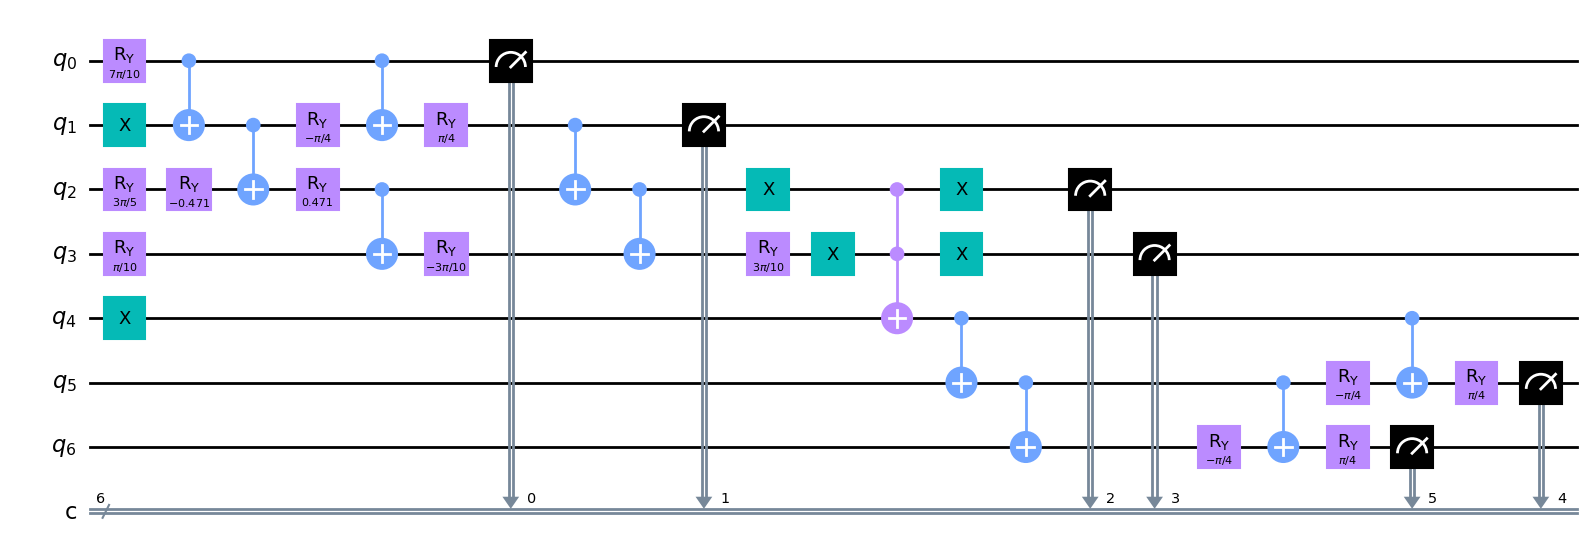

In [42]:
qc.draw(output="mpl")

In [ ]:
qc = QuantumCircuit(1)
qc.x(0)
qc.rz(-np.pi * 0.1, 0)

qc.measure_all()

# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=4096).result()
counts = results.get_counts(qc)

print(len(counts))
# 绘制直方图
plot_histogram(counts)

## 3 heavy atoms

In [65]:
num_heavy_atom = 3
num_qubits = num_heavy_atom*(num_heavy_atom+1)
num_ancilla_qubits = num_heavy_atom - 1
qc = QuantumCircuit(num_qubits+num_ancilla_qubits, num_qubits)
build_two_atoms(qc, [0.7, 0.3, 0.6, 0.3, 0.2, 0.6])
build_bond_type_circuit(qc, 2, [0.5, 0.5])
if num_heavy_atom - 2:
    for heavy_idx in range(3, num_heavy_atom+1):
        atom_type_weight_vector = [random.random() for _ in range(3)]
        bond_type_weight_vector = np.array([random.random() for _ in range((heavy_idx-1)*2)])
        bond_type_weight_vector = bond_type_weight_vector / np.sum(bond_type_weight_vector)
        build_atom_type_circuit(qc, heavy_idx, atom_type_weight_vector)
        build_bond_type_circuit(qc, heavy_idx, bond_type_weight_vector)


effective_qubit_index = list(range(num_qubits+num_ancilla_qubits))
for j in range(2, num_heavy_atom+1):
    ancilla_qubit_number = 2*j + (j-1)**2 - 1
    effective_qubit_index.remove(ancilla_qubit_number)
print(effective_qubit_index)
qc.measure(effective_qubit_index, list(range(num_qubits)))

# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=4096*8).result()
counts = results.get_counts(qc)

data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16)
print(len(counts))
# plot_histogram(counts)
# qc.draw(output="mpl")

[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13]
137


/tmp/ipykernel_264379/1365741785.py:27: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(qc, backend=simulator, shots=4096*8).result()


/beegfs/home/lungyi45/.conda/envs/qmg/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


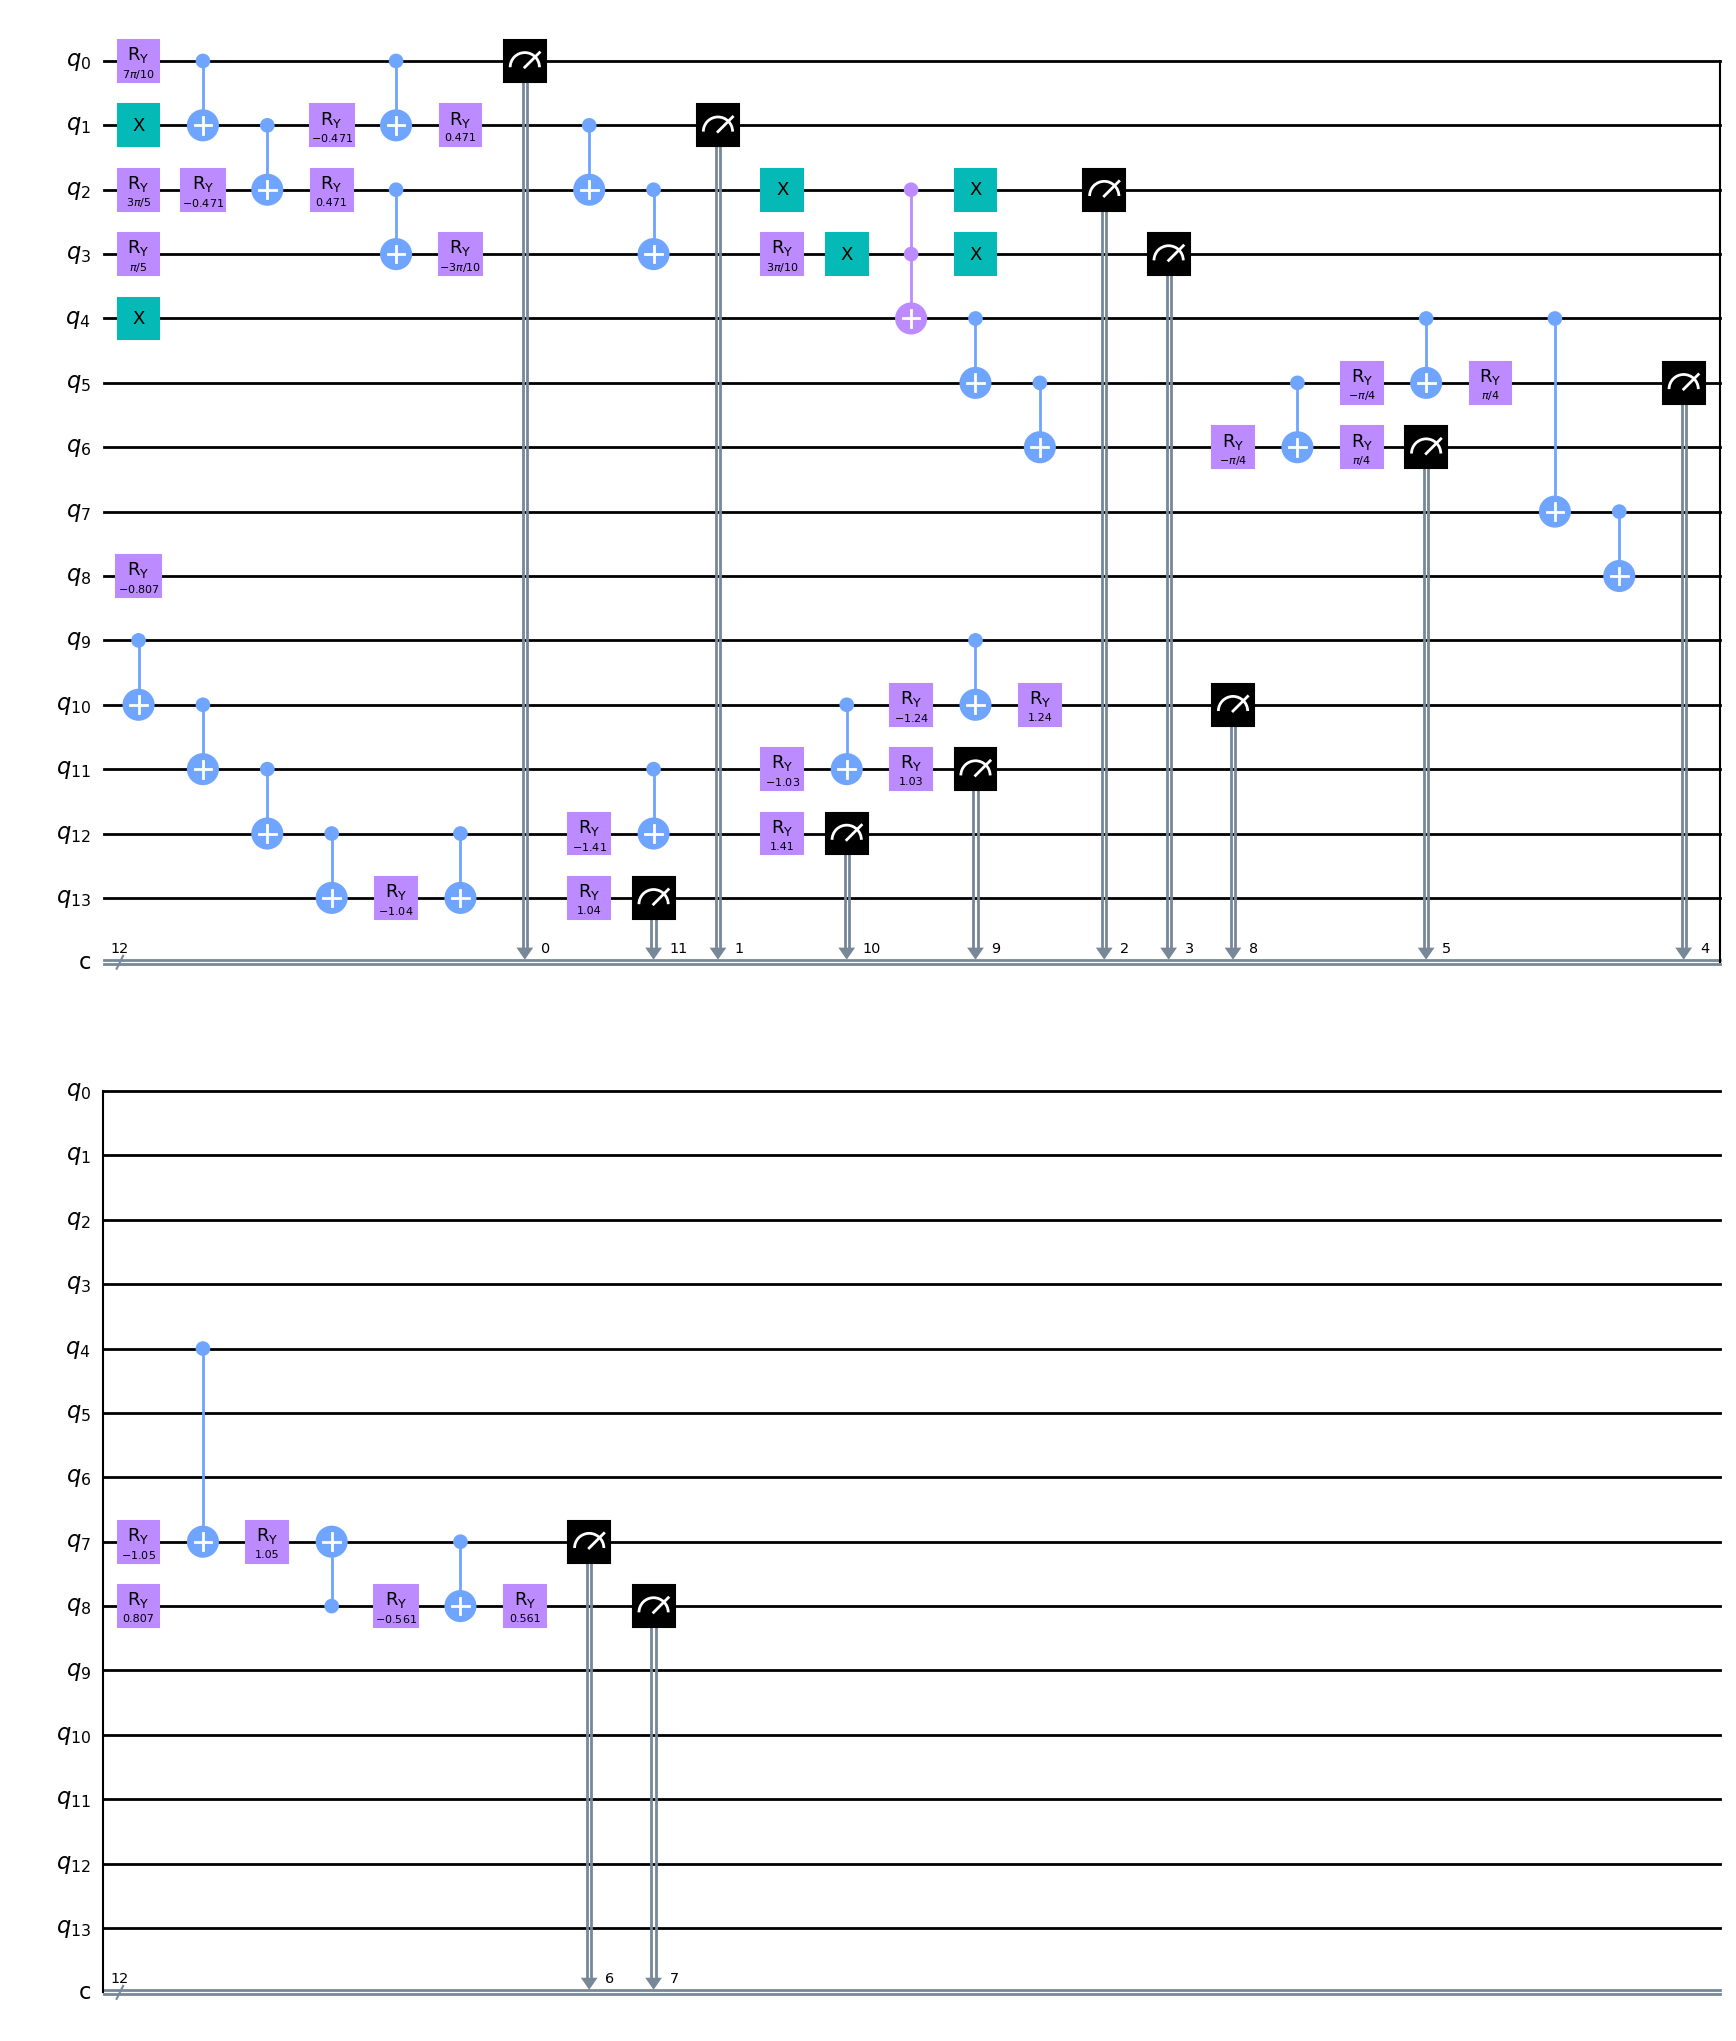

In [48]:
qc.draw(output="mpl")

In [74]:
def post_process_quantum_state(result_state: str, num_heavy_atom: int):
    """
    Reverse the qiskit outcome state and change the order to meet the definition of node vector and adjacency matrix.

    :param result_state: computational state derived from qiskit measurement outcomes
    :return: str of post-processed quantum state
    """
    assert len(result_state) == num_heavy_atom*(num_heavy_atom+1)
    result_state = result_state[::-1]
    quantum_state = ""
    for i in range(num_heavy_atom):
        atom_start_idx = i*2 + i*(i-1)
        quantum_state += result_state[atom_start_idx:atom_start_idx+2]
    for i in range(1, num_heavy_atom):
        for a_k, j in enumerate(range(i, num_heavy_atom)):
            bond_start_idx = (i+1)*2 + 2*a_k + j*(j-1) + (i-1)*2
            quantum_state += result_state[bond_start_idx:bond_start_idx+2]
    return quantum_state

data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=3, ncpus=16)
for key, value in counts.items():
    # quantum_state = key[::-1]
    # smiles = data_generator.QuantumStateToSmiles(quantum_state)
    # print(quantum_state, value)
    print(key, post_process_quantum_state(key, 3))
    print(data_generator.QuantumStateToSmiles(post_process_quantum_state(key, 3)))

000000000111 111000000000
N.O
000000101001 100100010000
CO
000001111001 100110110000
None
000000100110 011000010000
CO
000000111101 101100110000
None
000000001010 010100000000
C.C
000011010111 111011100000
N.N=O
000011001011 110111000000
C.N.N
000011010110 011011100000
C=O.N
000001101010 010110010000
CC.O
000011101101 101111010000
N.NO
000000011011 110100100000
C=N
000011111010 010111110000
C#C.N
000001001001 100110000000
C.O.O
000001001101 101110000000
N.O.O
000011101111 111111010000
N.NN
000010011110 011101100000
C.C=N
000010001010 010101000000
C.C.C
000010000101 101001000000
C.O.O
000011001101 101111000000
N.N.O
000010101110 011101010000
C.CN
000011101011 110111010000
CN.N
000001001111 111110000000
N.N.O
000011100101 101011010000
N.OO
000011110111 111011110000
None
000001001110 011110000000
C.N.O
000000001111 111100000000
N.N
000001111101 101110110000
None
000011111101 101111110000
None
000010000111 111001000000
C.N.O
000001011010 010110100000
C=C.O
000001000110 011010000000
C.O.O
0